 Findings to cluster data only with the descrptipn and priority columns Using Embeddings models, K-means to cluster , and LLM To assigne a title to each cluster and give a short description

Libraries Needed

In [ ]:
import pandas as pd
import random
import openai
import chardet
import re
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from tqdm import tqdm

Defining Funtions to clean unwanted caracters

In [5]:
# Clean descriptions
def clean_description(text):
    text = str(text).lower()
    text = re.sub(r'https?://\\S+', '', text)  # Remove URLs
    text = re.sub(r'\\n|\\r|\\t', ' ', text)   # Remove line breaks and tabs
    text = re.sub(r'[^a-z0-9 ]', ' ', text)    # Keep only alphanumerics
    text = re.sub(r'\\b\\w*\\d\\w*\\b', '', text)  # Remove words with numbers (device codes, like 21342B62DB)
    text = re.sub(r'\\s+', ' ', text).strip()  # Collapse spaces
    return text


In [17]:
# Extract numeric priority
def clean_priority(val):
    val = str(val)
    return int(''.join(filter(str.isdigit, val))) if any(char.isdigit() for char in val) else None

Funtion to detect the type of csv and save into the regulas csv file for easy manipulation

In [ ]:
# Step 1: Detect encoding just once
with open('Testfile_ST-MDE.csv', 'rb') as f:
    result = chardet.detect(f.read())
    print(result)

# Step 2: Read the CSV with detected encoding
df = pd.read_csv('Testfile_ST-MDE.csv', encoding=result['encoding'])

# Step 3: Save a cleaned version as proper UTF-8
df.to_csv('convert_dataset.csv', index=False, encoding='utf-8')


Loading the convert data set

In [30]:
df = pd.read_csv('clean_dataset.csv', index_col = 'number')

In [31]:
df.head(10)

,short_description,description,priority,u_region,u_division,cmdb_ci,u_close_code
number,,,,,,,
INC6658799,Mobile Office | My error is not listed / repor...,"This ticket was created by a store employee, s...",Prio 3,GB,LDL,ST-MDE,Resolved by Problem Ticket
INC7053991,VLC-3056-Mobile Office – PDA Terminal - Honeywell,Here we have exactly the same incident as INC...,Prio 3,ES,LDL,ST-MDE,Solved - Error did not appear again
INC7170689,LFR - Store 1696 - WH08 - Honeywell Mobile Dev...,"The mobile device 21342B62DB on store 1696, wa...",Prio 3,FR,LDL,ST-MDE,Works as designed
INC7181866,Store 2507 - WH11 - Honeywell Mobile Device Lo...,Mobile device (21349B1921) locked in landscape...,Prio 3,FR,LDL,ST-MDE,Works as designed
INC7185888,LFR - Store 3660 - WH12 - Honeywell Device - T...,Since the Android 10 update on the 21172B39DD ...,Prio 3,FR,LDL,ST-MDE,Works as designed
INC7255265,2659 - MUZILLAC - DR07 - INP MOBI # S/N : 2117...,--------------- LIDL ---------------\r\n> Expé...,Prio 2,FR,LDL,ST-MDE,Works as designed
INC7300612,0530 - CLERMONT-FERRAND - DR12 - MoBi - perdu ...,--------------- LIDL ---------------\r\n> Expé...,Prio 3,FR,LDL,ST-MDE,Works as designed
INC7337800,1090 - Lidl-Store: PARIS - DR10 - Mobi - aucun...,------------ LIDL ---------------\r\n> Expédit...,Prio 3,FR,LDL,ST-MDE,Works as designed
INC7345428,3930 - Lidl-Store: BAGNOLET - DR10 - Mobi - Pr...,------------ LIDL ---------------\r\n> Expédit...,Prio 3,FR,LDL,ST-MDE,Works as designed


In [32]:
df_description = df["description"]
df_description

number
INC6658799     This ticket was created by a store employee, s...
INC7053991     Here  we have exactly the same incident as INC...
INC7170689     The mobile device 21342B62DB on store 1696, wa...
INC7181866     Mobile device (21349B1921) locked in landscape...
INC7185888     Since the Android 10 update on the 21172B39DD ...
                                     ...                        
INC10694407    Store reported that hydra on scanner 21354B477...
INC10694222    (contacto/cargo/tel. de contacto):     Isidro ...
INC10694489    (contacto/cargo/tel. de contacto):     eduardo...
INC10694601    This ticket was created by a store employee, s...
INC10694613    2560 Cieszyn; tel: 33 8513407\nMA?GORZATA KROM...
Name: description, Length: 49375, dtype: object

In [33]:
# calling the first funtion to clean variable
df['clean_desc'] = df['description'].apply(clean_description)

In [34]:
# calling the second funtion to clean variable
df['priority_num'] = df['priority'].apply(clean_priority)

In [35]:
df.head(10)

,short_description,description,priority,u_region,u_division,cmdb_ci,u_close_code,clean_desc,priority_num
number,,,,,,,,,
INC6658799,Mobile Office | My error is not listed / repor...,"This ticket was created by a store employee, s...",Prio 3,GB,LDL,ST-MDE,Resolved by Problem Ticket,this ticket was created by a store employee s...,3
INC7053991,VLC-3056-Mobile Office – PDA Terminal - Honeywell,Here we have exactly the same incident as INC...,Prio 3,ES,LDL,ST-MDE,Solved - Error did not appear again,here we have exactly the same incident as inc...,3
INC7170689,LFR - Store 1696 - WH08 - Honeywell Mobile Dev...,"The mobile device 21342B62DB on store 1696, wa...",Prio 3,FR,LDL,ST-MDE,Works as designed,the mobile device 21342b62db on store 1696 wa...,3
INC7181866,Store 2507 - WH11 - Honeywell Mobile Device Lo...,Mobile device (21349B1921) locked in landscape...,Prio 3,FR,LDL,ST-MDE,Works as designed,mobile device 21349b1921 locked in landscape...,3
INC7185888,LFR - Store 3660 - WH12 - Honeywell Device - T...,Since the Android 10 update on the 21172B39DD ...,Prio 3,FR,LDL,ST-MDE,Works as designed,since the android 10 update on the 21172b39dd ...,3
INC7255265,2659 - MUZILLAC - DR07 - INP MOBI # S/N : 2117...,--------------- LIDL ---------------\r\n> Expé...,Prio 2,FR,LDL,ST-MDE,Works as designed,lidl exp dition priorit ...,2
INC7300612,0530 - CLERMONT-FERRAND - DR12 - MoBi - perdu ...,--------------- LIDL ---------------\r\n> Expé...,Prio 3,FR,LDL,ST-MDE,Works as designed,lidl exp dition type ...,3
INC7337800,1090 - Lidl-Store: PARIS - DR10 - Mobi - aucun...,------------ LIDL ---------------\r\n> Expédit...,Prio 3,FR,LDL,ST-MDE,Works as designed,lidl exp dition priorit ...,3
INC7345428,3930 - Lidl-Store: BAGNOLET - DR10 - Mobi - Pr...,------------ LIDL ---------------\r\n> Expédit...,Prio 3,FR,LDL,ST-MDE,Works as designed,lidl exp dition priorit ...,3


In [36]:
df_des = df["clean_desc"]
df_des

number
INC6658799     this ticket was created by a store employee  s...
INC7053991     here  we have exactly the same incident as inc...
INC7170689     the mobile device 21342b62db on store 1696  wa...
INC7181866     mobile device  21349b1921  locked in landscape...
INC7185888     since the android 10 update on the 21172b39dd ...
                                     ...                        
INC10694407    store reported that hydra on scanner 21354b477...
INC10694222    contacto cargo tel  de contacto       isidro  ...
INC10694489    contacto cargo tel  de contacto       eduardo ...
INC10694601    this ticket was created by a store employee  s...
INC10694613    2560 cieszyn  tel  33 8513407 ma gorzata kromc...
Name: clean_desc, Length: 49375, dtype: object

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49375 entries, INC6658799 to INC10694613
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   short_description  49375 non-null  object
 1   description        49374 non-null  object
 2   priority           49375 non-null  object
 3   u_region           49232 non-null  object
 4   u_division         49375 non-null  object
 5   cmdb_ci            49375 non-null  object
 6   u_close_code       49375 non-null  object
 7   clean_desc         49375 non-null  object
 8   priority_num       49375 non-null  int64 
dtypes: int64(1), object(8)
memory usage: 4.8+ MB


In [38]:
df.shape

(49375, 9)

In [ ]:
# Optional: drop rows with missing nullscleaned descriptions or priority
df.dropna(subset=['clean_desc', 'priority_num'], inplace=True)

In [39]:
# Drop original 'description' and 'priority'
df_clean = df.drop(columns=['description', 'priority'])


In [40]:
df_null_sum = df_clean.isnull().sum()
df_null_sum

short_description      0
u_region             143
u_division             0
cmdb_ci                0
u_close_code           0
clean_desc             0
priority_num           0
dtype: int64

In [41]:
df_clean

,short_description,u_region,u_division,cmdb_ci,u_close_code,clean_desc,priority_num
number,,,,,,,
INC6658799,Mobile Office | My error is not listed / repor...,GB,LDL,ST-MDE,Resolved by Problem Ticket,this ticket was created by a store employee s...,3
INC7053991,VLC-3056-Mobile Office – PDA Terminal - Honeywell,ES,LDL,ST-MDE,Solved - Error did not appear again,here we have exactly the same incident as inc...,3
INC7170689,LFR - Store 1696 - WH08 - Honeywell Mobile Dev...,FR,LDL,ST-MDE,Works as designed,the mobile device 21342b62db on store 1696 wa...,3
INC7181866,Store 2507 - WH11 - Honeywell Mobile Device Lo...,FR,LDL,ST-MDE,Works as designed,mobile device 21349b1921 locked in landscape...,3
INC7185888,LFR - Store 3660 - WH12 - Honeywell Device - T...,FR,LDL,ST-MDE,Works as designed,since the android 10 update on the 21172b39dd ...,3
...,...,...,...,...,...,...,...
INC10694407,SK4320 - problem with hydra,SK,KFL,ST-MDE,Software / Application Issue,store reported that hydra on scanner 21354b477...,2
INC10694222,Mobile Office – PDA Terminal 01 - Honeywell,ES,LDL,ST-MDE,Solved - Error did not appear again,contacto cargo tel de contacto isidro ...,3
INC10694489,Mobile Office – PDA Terminal - Honeywell,ES,LDL,ST-MDE,Solved - Error did not appear again,contacto cargo tel de contacto eduardo ...,3


In [ ]:
# 🧠 Generate embeddings from text capture the semantic meaning of reviews, making them better suited for clustering.
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')  
tqdm.pandas()  
descriptions = df_clean['clean_desc'].astype(str).tolist()
embeddings = model.encode(descriptions, show_progress_bar=True)
# Store in DataFrame as new column
df_clean['embedding'] = embeddings.tolist()


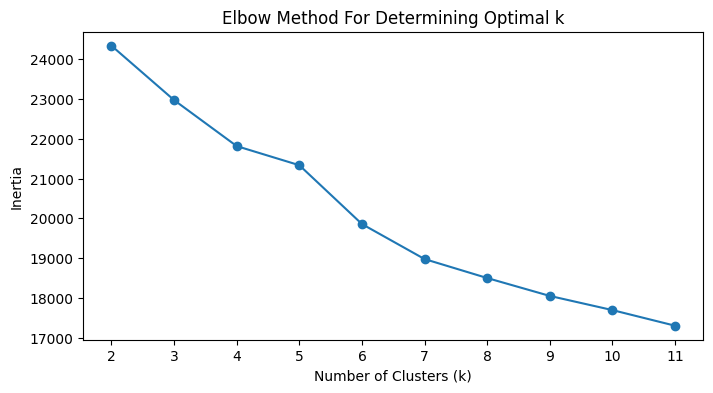

In [17]:
import matplotlib.pyplot as plt
import numpy as np
# Define a range of possible clusters
k_values = range(2, 12)
inertias = []

# For each k, perform KMeans clustering and record the inertia
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings)
    inertias.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 4))
plt.plot(k_values, inertias, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method For Determining Optimal k")
plt.xticks(k_values)
plt.show()


In [18]:
# 🔀  Cluster the embeddings
n_clusters = 7  
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(embeddings)
df['cluster'] = labels


In [19]:
# 👀  Inspect each cluster manually
for i in range(n_clusters):
    print(f"\n🔹 Cluster {i}:")
    print(df[df['cluster'] == i]['description'].head(5).to_string(index=False))



🔹 Cluster 0:
SN: 22007B1808\r\nMAC: \t\t001020f424aa\r\nIP: ...
SN: 22024B297E\r\nMAC: \t001020f467fa\r\nIP: \t...
SN: 21355B2C97\r\nMAC: \t001020f3cc7a\r\nIP: \t...
Fehlerbeschreibung : MDE hat einen riss im Disp...
SN: 20345B5966\r\nMAC: \t001020eecd5e\r\nIP: \t...

🔹 Cluster 1:
Here  we have exactly the same incident as INC7...
The mobile device 21342B62DB on store 1696, war...
Mobile device (21349B1921) locked in landscape ...
Since the Android 10 update on the 21172B39DD H...
--------------- LIDL ---------------\r\n\r\n> E...

🔹 Cluster 2:
This ticket was created by a store employee, st...
This ticket was created by a store employee, st...
This ticket was created by a store employee, st...
This ticket was created by a store employee, st...
This ticket was created by a store employee, st...

🔹 Cluster 3:
This ticket was created by a store employee, st...
This ticket was created by a store employee, st...
This ticket was created by a store employee, st...
This ticket was created by

In [21]:
def categorize_and_explain_cluster(descriptions):
    sample_size = min(30, len(descriptions))

    # Randomly select 'sample_size' reviews from the cluster
    random_sample = random.sample(descriptions, sample_size)

    text_sample = "\n".join(random_sample)
    prompt = (
        "These are product descriptions from one cluster:\n\n" +
        text_sample +
        "\n\nBased on these reviews, assign a general category (a short label) for this group, "
        "and explain in detail the key factors or recurring themes that led you to choose this category."
    )
    
    response = openai.ChatCompletion.create(
        model="gpt-4o-mini-2024-07-18",  # Latest model as requested
        messages=[{"role": "user", "content": prompt}]
    )
    
    return response["choices"][0]["message"]["content"]


In [28]:
# Dictionary to hold each cluster's summary and explanation
cluster_summaries = {}

for cluster_label in sorted(df['cluster'].unique()):
    # Get all reviews for this cluster as a list
    descriptions = df[df['cluster'] == cluster_label]['description'].tolist()

    # Llamar a la función que categoriza y explica el cluster
    summary = categorize_and_explain_cluster(descriptions)

    cluster_summaries[cluster_label] = summary
    print(f"\nCluster {cluster_label} Summary and Explanation:\n")
    print(summary)
    
# Save the DataFrame with clusters to a new CSV file
df.to_csv("clustersHG.csv", index=False)


Cluster 0 Summary and Explanation:

### Category: **Device Malfunctions and Damage**

#### Key Factors and Recurring Themes:

1. **Device Operational Issues**:
   - A majority of the entries describe devices that are not functioning as intended. For example, numerous entries indicate devices that fail to power on (e.g., "MDE fährt nicht hoch," "Gerät lässt sich nicht mehr einschalten, Akkutausch erfolglos"), suggesting a recurring issue with either the power components or battery functionality of the devices.

2. **Physical Damage**:
   - There are several instances of noted physical defects, especially regarding the displays. Terms like "Display ist gesprungen," "Display defekt," and "Displayschaden durch Sturz" appear multiple times, revealing that many devices have been subjected to physical impacts or mishandling, leading to damage.

3. **Connectivity Problems**:
   - Problems related to network connectivity are common as well. Phrases like "Verbindet sich nicht mit dem Wlan" and 

### clustering or semantic search Reviews Using KMeans

In this step, we apply the KMeans clustering algorithm to group the reviews into clusters based on their embeddings. The embeddings, generated in the previous step, serve as input features for the clustering process.

We specify the number of clusters (`n_clusters`) as 5 and use the `fit_predict` method of the KMeans model to assign each review to a cluster. The resulting cluster labels are stored in a new column `cluster` in the dataframe `df`. This allows us to analyze and interpret the reviews based on their assigned clusters.

## Additional information

https://huggingface.co/sentence-transformers/all-mpnet-base-v2

all-mpnet-base-v2=  (~109 M parámetros),

https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

all-MiniLM-L6-v2 =  (~22.7 M parámetros),

https://huggingface.co/sentence-transformers/distiluse-base-multilingual-cased-v2

distiluse-base-multilingual-cased-v2 = (~135 M parámetros)






In [29]:

cluster_names = {
    0: "MDE Device Malfunctions",
    1: "Device Malfunction and Replacement Requests",
    2: "Device and Application Issues in Retail Stores",
    3: "Device and Application Malfunctions in Retail Operations",
    4: "Equipment Malfunctions and Replacement Requests",
    5: "Device Malfunctions and Connectivity Issues",
    6: "Hardware Connectivity Issues"

}

# new column with descriptive cluster names
df['cluster_name'] = df['cluster'].map(cluster_names)



# Save the updated DataFrame with descriptive names to CSV
df.to_csv("clusters1_namedHG.csv", index=False)


In [32]:
df2 = pd.read_csv("clusters1_namedHG.csv")


In [33]:
df2

,number,short_description,description,priority,u_region,u_division,cmdb_ci,u_close_code,cluster,cluster_name
0,INC6658799,Mobile Office | My error is not listed / repor...,"This ticket was created by a store employee, s...",Prio 3,GB,LDL,ST-MDE,Resolved by Problem Ticket,2,Device and Application Issues in Retail Stores
1,INC7053991,VLC-3056-Mobile Office – PDA Terminal - Honeywell,Here we have exactly the same incident as INC...,Prio 3,ES,LDL,ST-MDE,Solved - Error did not appear again,1,Device Malfunction and Replacement Requests
2,INC7170689,LFR - Store 1696 - WH08 - Honeywell Mobile Dev...,"The mobile device 21342B62DB on store 1696, wa...",Prio 3,FR,LDL,ST-MDE,Works as designed,1,Device Malfunction and Replacement Requests
3,INC7181866,Store 2507 - WH11 - Honeywell Mobile Device Lo...,Mobile device (21349B1921) locked in landscape...,Prio 3,FR,LDL,ST-MDE,Works as designed,1,Device Malfunction and Replacement Requests
4,INC7185888,LFR - Store 3660 - WH12 - Honeywell Device - T...,Since the Android 10 update on the 21172B39DD ...,Prio 3,FR,LDL,ST-MDE,Works as designed,1,Device Malfunction and Replacement Requests
...,...,...,...,...,...,...,...,...,...,...
49370,INC10694407,SK4320 - problem with hydra,Store reported that hydra on scanner 21354B477...,Prio 2,SK,KFL,ST-MDE,Software / Application Issue,1,Device Malfunction and Replacement Requests
49371,INC10694222,Mobile Office – PDA Terminal 01 - Honeywell,(contacto/cargo/tel. de contacto): Isidro ...,Prio 3,ES,LDL,ST-MDE,Solved - Error did not appear again,5,Device Malfunctions and Connectivity Issues
49372,INC10694489,Mobile Office – PDA Terminal - Honeywell,(contacto/cargo/tel. de contacto): eduardo...,Prio 3,ES,LDL,ST-MDE,Solved - Error did not appear again,5,Device Malfunctions and Connectivity Issues
49373,INC10694601,Mobile Office | Mijn probleem is niet opgelijs...,"This ticket was created by a store employee, s...",Prio 3,BE,LDL,ST-MDE,Software / Application Issue,3,Device and Application Malfunctions in Retail ...
